In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from itertools import product
from simulation_utils import *
from test_utils import *

from os import chdir

from tqdm.auto import tqdm
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.style.use('ggplot')


In [2]:
def simulate(n_reps = 3, n_sample=500, n_quant = 128,
                kernel_X = 'constant',sig_X=5,
                kernel_Y = 'constant',sig_Y=5,
                sig_Z=5,beta1=1,
                box_params = {'max_depth':1,'n_estimators':200,'eta':0.1},
                L2_pen=1,n_splits=5,
                dependency = 0):

    (gam_plug,gam_corrected,gam_double,
        T_plug,T_corrected,T_double,
        sig_list,sigd_list) = ([] for _ in range(8))

    data_sampler = cox_sampler(sig_X,sig_Y,sig_Z,dependency,beta1,kernel_X,kernel_Y,n_quant)
    data_sampler.scale_and_set_baseline()

    for _ in tqdm(range(n_reps), leave=False):
        X,Y,Z,tau = data_sampler.sample_all(n_sample)

        g_p, g_c, sig, best_params = compute_gamma(tau,Z,X,box_params,n_quant,L2_pen=L2_pen,cross_validate=True)
        g_d, sig_d = compute_gamma_double(tau,Z,X,best_params, n_quant, n_splits=n_splits,L2_pen=L2_pen)

        gam_plug.append(g_p[-1])
        gam_corrected.append(g_c[-1])
        gam_double.append(g_d[-1])
        T_plug.append(np.linalg.norm(g_p,ord=np.inf))
        T_corrected.append(np.linalg.norm(g_c,ord=np.inf))
        T_double.append(np.linalg.norm(g_d,ord=np.inf))
        sig_list.append(sig[-1])
        sigd_list.append(sig_d[-1])
    
    df = pd.DataFrame({
        "gam_plug":gam_plug,
        "gam_corrected":gam_corrected,
        "gam_double":gam_double,
        "T_plug":T_plug,
        "T_corrected":T_corrected,
        "T_double":T_double,
        "sigma":sig_list,
        "sigma_double":sigd_list,
        "n_sample": n_sample*np.ones(n_reps),
        "beta1": beta1*np.ones(n_reps),
        "kernel_X": [kernel_X]*n_reps,
        "kernel_Y": [kernel_Y]*n_reps,
        "alt_param": [dependency]*n_reps
    })
    return df

In [5]:
simulation_data = []

## Simulation settings
kernel_list = ['constant','exp', 'sine']
#kernel_list = ['constant']
beta_list = [-1,1]
sample_sizes = [100,500,1000,2000]
dependency_param = [0,10,20,30]
n_sim = len(kernel_list) * len(beta_list) * len(sample_sizes) * len(dependency_param)
param_grid = product(kernel_list,beta_list,sample_sizes,dependency_param)

for kernel,beta_1,sample_size,dependency in tqdm(param_grid, position = 0, leave=True, total=n_sim):
    sim_data = simulate(
        n_reps = 2, n_sample=sample_size,
        sig_X=5, kernel_X=kernel,
        sig_Y=5, kernel_Y=kernel,
        sig_Z=5,
        beta1=beta_1,
        box_params = {'max_depth':2,'n_estimators':200,'eta':0.1},
        L2_pen=0.001,n_splits=5,
        dependency=dependency
    )
    simulation_data.append(sim_data)
full_data = pd.concat(simulation_data)

  3%|▎         | 3/96 [00:07<03:59,  2.58s/it]


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/Users/bwq666/opt/anaconda3/envs/boxhed2.0/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/bwq666/opt/anaconda3/envs/boxhed2.0/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/bwq666/Documents/BoxHed/BoXHED2.0/model_selection.py", line 103, in _run_batch_process
    trained_models = Parallel(n_jobs=-1, prefer="threads")(delayed(_fit_single_model)(param_dict)
  File "/Users/bwq666/opt/anaconda3/envs/boxhed2.0/lib/python3.8/site-packages/joblib/parallel.py", line 1061, in __call__
    self.retrieve()
  File "/Users/bwq666/opt/anaconda3/envs/boxhed2.0/lib/python3.8/site-packages/joblib/parallel.py", line 940, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/Users/bwq666/opt/anaconda3/envs/boxhed2.0/lib/python3.8/multiprocessing/pool.py", line 765, in get
    self.wait(timeout)
  File "/Users/bwq666/op

In [11]:
path = '/Users/bwq666/Documents/BoxHed/'
if 1:
    with open(path+'/sim_data/' + 'alternative.pkl', 'wb') as f:
        pickle.dump(full_data, f)

if 0:
    with open(path+'/sim_data/' + 'full_data_independent1.pkl', 'rb') as f:
        #sim_data,n_samples = pickle.load(f)
        full_data2 = pickle.load(f)


In [10]:
len(simulation_data)

125

In [73]:
simple_data = full_data[(full_data['kernel_X']=='constant')*(full_data['beta1']==1)]

In [13]:
sim_data = simulate(
    n_reps = 30, n_sample=200, n_quant=128,
    sig_X=5, kernel_X='constant',
    sig_Y=5, kernel_Y='constant',
    sig_Z = 5,
    beta1=1,
    box_params = {'max_depth':2,'n_estimators':200,'eta':0.1},
    L2_pen=0.0001,n_splits=5,
    dependency=5
)

In [55]:
p_value_corr = lambda x: 1-BM_supnorm_cdf(np.sqrt(x[2])*x[0]/np.sqrt(x[1])) # x = (statistic, variance, samplesize)
p_value_double = lambda x: 1-BM_supnorm_cdf(np.sqrt(x[2])*x[0]*np.sqrt(4/5)/np.sqrt(x[1])) # x = (statistic, variance, samplesize)
#sim_data['p_plug'] = sim_data[['T_plug','sigma','n_sample']].apply(p_value_corr,axis=1)
sim_data['p_corr'] = sim_data[['T_corrected','sigma','n_sample']].apply(p_value_corr,axis=1)
sim_data['p_double'] = sim_data[['T_double','sigma_double','n_sample']].apply(p_value_double,axis=1)

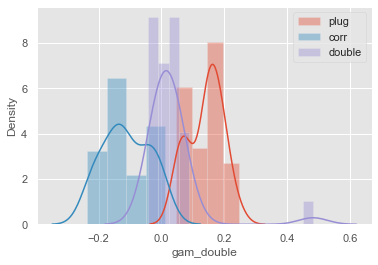

In [56]:
sns.distplot(sim_data['gam_plug'],label='plug')
sns.distplot(sim_data['gam_corrected'],label='corr')
sns.distplot(sim_data['gam_double'],label='double')
plt.legend()
plt.show()

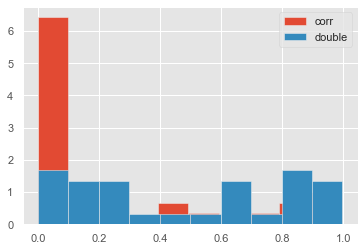

In [57]:
plt.hist(sim_data['p_corr'],density=True,label="corr")
plt.hist(sim_data['p_double'],density=True,label="double")
plt.legend()
plt.show()

In [39]:
sampler = cox_sampler(
    sig_X=0,sig_Y=0,sig_Z=0,kernel_X='constant',kernel_Y='sine'
)

In [3]:
X,Y,Z,tau = sampler.sample_all(500)

Scaled baseline coefficient: 18


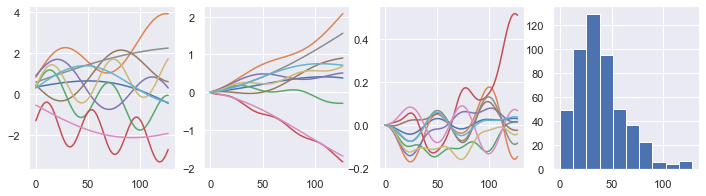

In [4]:
plt.subplots(1,3,figsize=(12,3))
plt.subplot(141); plt.plot(Z[0:10,...].transpose())
plt.subplot(142); plt.plot(X[0:10,...].transpose()); 
plt.subplot(143); plt.plot(Y[0:10,...].transpose())
plt.subplot(144); plt.hist(tau)
plt.show()

## Old version of code

In [19]:
def simulate(n_reps = 3, n_samples=500, quantiles = 128,
                kernel_X = 'constant',sig_X=3,
                kernel_Y = 'constant',sig_Y=3,
                beta_1=-2,
                box_params = {'max_depth':1,'n_estimators':200,'eta':0.1},
                L2_pen=1,n_splits=5,
                dependency = 0,
                plot_sample=True,
                Z_jump=False):

    (gam_plug,gam_corrected,gam_double,
        T_plug,T_corrected,T_double,
        sig_list,sigd_list) = ([] for _ in range(8))

    k_X = create_kernel(kernel_X)
    k_Y = create_kernel(kernel_Y)
    
    ### preliminary sample to get an appropriate hazard rate
    Z,X,Y = sample_ZXY(k_Y,k_Y,sig_X,sig_Y,n_samples,quantiles,Z_jump)
    #W = Y + np.log(1+(dependency/np.sqrt(n_samples))*np.exp(Z))
    baseline_coeff = 2
    baseline = lambda t: baseline_coeff * t**2
    tau = sample_tau(Z,Y,baseline,np.exp,beta_1=beta_1)

    for _ in range(30):
        if 100*sum(tau==quantiles)<n_samples:
            break
        baseline_coeff += 1
        tau = sample_tau(Z,Y,baseline,np.exp,beta_1=beta_1)

    if plot_sample:
        plt.subplots(1,3,figsize=(12,3))
        plt.subplot(141); plt.plot(Z[0:10,...].transpose())
        plt.subplot(142); plt.plot(X[0:10,...].transpose()); 
        plt.subplot(143); plt.plot(Y[0:10,...].transpose())
        plt.subplot(144); plt.hist(tau)
        plt.show()

    for _ in tqdm(range(n_reps), leave=False):
        Z,X,Y = sample_ZXY(k_X,k_Y,sig_X,sig_Y,n_samples,quantiles,Z_jump)
        #W = Y + (dependency/np.sqrt(n_samples))*Z
        tau = sample_tau(X,Y,baseline,np.exp,beta_1=beta_1)
        #tau = sample_tau_confounded(X,Y,Z,dependency,baseline,np.exp,return_hazard=False,beta_1=beta_1)
        
    
        g_p, g_c, sig, best_params = compute_gamma(tau,Z,X,box_params,quantiles,L2_pen=L2_pen,cross_validate=True)
        g_d, sig_d = compute_gamma_double(tau,Z,X,best_params, quantiles, n_splits=n_splits,L2_pen=L2_pen)

        gam_plug.append(g_p[-1])
        gam_corrected.append(g_c[-1])
        gam_double.append(g_d[-1])
        T_plug.append(np.linalg.norm(g_p,ord=np.inf))
        T_corrected.append(np.linalg.norm(g_c,ord=np.inf))
        T_double.append(np.linalg.norm(g_d,ord=np.inf))
        sig_list.append(sig[-1])
        sigd_list.append(sig_d[-1])
    
    df = pd.DataFrame({
        "gam_plug":gam_plug,
        "gam_corrected":gam_corrected,
        "gam_double":gam_double,
        "T_plug":T_plug,
        "T_corrected":T_corrected,
        "T_double":T_double,
        "sigma":sig_list,
        "sigma_double":sigd_list,
        "n_sample": n_samples*np.ones(n_reps),
        "beta1": beta_1*np.ones(n_reps),
        "kernel_X": [kernel_X]*n_reps,
        "kernel_Y": [kernel_Y]*n_reps
    })

    return df, n_samples

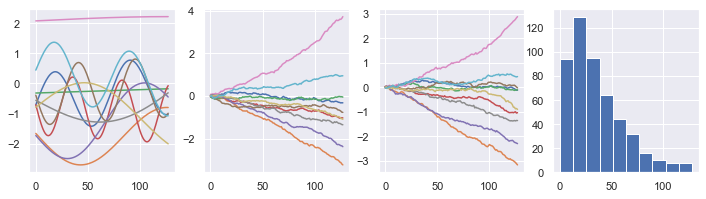

In [36]:
sim_data, n_samples = simulate(
    n_reps = 2, n_samples=500, quantiles = 128,
    sig_X=3, kernel_X='sine',
    sig_Y=3, kernel_Y='exp',
    beta_1=-2,
    box_params = {'max_depth':1,'n_estimators':200,'eta':0.1},
    L2_pen=0.001,n_splits=5,
    plot_sample=True,
    Z_jump=False,
    dependency=10
)

In [30]:
simulation_data = []

## Simulation settings
#kernel_list = ['constant','exp','sine']
kernel_list = ['constant']
beta_list = [-1]
sample_sizes = [100,200]
dependency_param = [0]
n_sim = len(kernel_list) * len(beta_list) * len(sample_sizes) * len(dependency_param)
param_grid = product(kernel_list,beta_list,sample_sizes,dependency_param)


for kernel,beta_1,sample_size,dependency in tqdm(param_grid, position = 0, total=n_sim):
    sim_data, n_samples = simulate(
        n_reps = 500, n_samples=sample_size, quantiles = 128,
        box_params = {'max_depth':2,'n_estimators':100,'eta':0.1},
        sig_X = 5,kernel_X=kernel,
        sig_Y = 5,kernel_Y=kernel,
        beta_1 = beta_1,
        L2_pen = 0.001,n_splits=10,
        plot_sample = False, dependency=dependency
    )
    sim_data['alt_param'] = dependency*np.ones(500)
    simulation_data.append(sim_data)
full_data = pd.concat(simulation_data)

100%|██████████| 16/16 [4:43:20<00:00, 1062.55s/it]


In [31]:
path = '/Users/bwq666/Documents/BoxHed/'
if 0:
    with open(path+'/sim_data/' + 'full_data_dependent2.pkl', 'wb') as f:
        pickle.dump(full_data, f)

if 0:
    with open(path+'/sim_data/' + 'full_data_independent1.pkl', 'rb') as f:
        #sim_data,n_samples = pickle.load(f)
        full_data2 = pickle.load(f)

# df1 = full_data
# df2 = full_data2
# combined = pd.concat([df1,df2])

In [53]:
df_melt = pd.melt(
    full_data, id_vars=['n_sample','beta1','kernel_Y'],value_vars=['gam_plug','gam_corrected','gam_double'])

In [54]:
df_melt['params'] = list(zip(df_melt.kernel_Y, df_melt.beta1))


In [21]:
for x in product(kernel_list,beta_list,sample_sizes,dependency_param):
    print(x)

('constant', -1, 100, 0)
('constant', -1, 100, 10)
('constant', -1, 100, 50)
('constant', -1, 100, 100)
('constant', -1, 200, 0)
('constant', -1, 200, 10)
('constant', -1, 200, 50)
('constant', -1, 200, 100)
('constant', -1, 500, 0)
('constant', -1, 500, 10)
('constant', -1, 500, 50)
('constant', -1, 500, 100)
('constant', -1, 1000, 0)
('constant', -1, 1000, 10)
('constant', -1, 1000, 50)
('constant', -1, 1000, 100)


In [27]:
full_data

,gam_plug,gam_corrected,gam_double,T_plug,T_corrected,T_double,sigma,sigma_double,n_sample,beta1,kernel_Y,kernel_Z,alt_param
0,-0.043003,0.007748,-0.098106,0.067838,0.008658,0.125340,0.034033,0.779698,100.0,-1.0,constant,constant,0
1,-0.160631,0.006594,0.511372,0.160631,0.013637,0.517779,0.029650,1.016023,100.0,-1.0,constant,constant,0
2,-0.147250,-0.003923,-0.050555,0.158276,0.009961,0.052983,0.021553,0.475274,100.0,-1.0,constant,constant,0
3,-0.007958,0.003131,-0.097677,0.034266,0.019119,0.196671,0.039646,1.227936,100.0,-1.0,constant,constant,0
4,-0.055318,0.015003,-0.045646,0.068570,0.017753,0.085624,0.022679,0.450110,100.0,-1.0,constant,constant,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.185883,0.116359,0.123313,0.186829,0.116592,0.123658,0.064823,0.075077,1000.0,-1.0,constant,constant,100
496,0.207495,0.126362,0.140016,0.207635,0.126382,0.140055,0.051352,0.058462,1000.0,-1.0,constant,constant,100
497,0.192089,0.110865,0.115907,0.192089,0.111342,0.116263,0.060346,0.069415,1000.0,-1.0,constant,constant,100
498,0.181432,0.112982,0.121732,0.181938,0.113229,0.121991,0.061330,0.068320,1000.0,-1.0,constant,constant,100


In [24]:
dep_par = np.array(np.repeat(dependency_param, 500).tolist()*4)

In [26]:
full_data['alt_param'] = dep_par

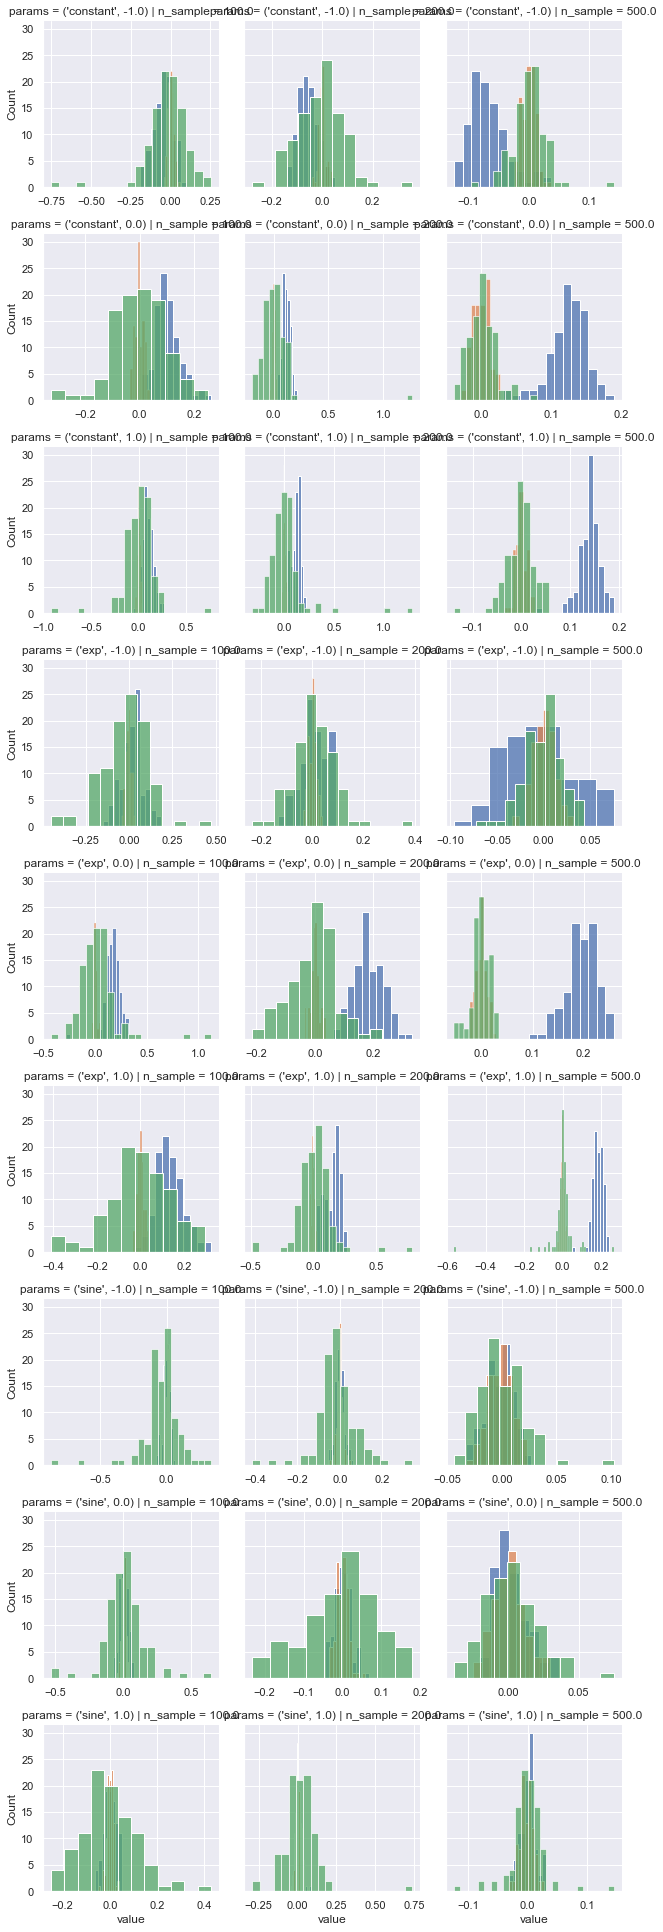

In [56]:
g = sns.FacetGrid(df_melt, col='n_sample', row='params', hue='variable',sharex=False)
g.map(sns.histplot, 'value');
plt.show()
#plt.savefig('./Plots/enpoint_hists.png')

### Plots

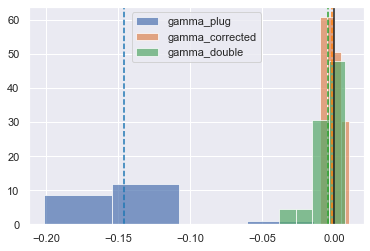

In [41]:
endpoint_p = sim_data["gam_plug"]
endpoint_c = sim_data["gam_corrected"]
endpoint_d = sim_data["gam_double"]

bins = len(sim_data)//5
plt.hist(endpoint_p,label="gamma_plug",bins=bins, density=True, alpha=0.7); plt.legend()
plt.hist(endpoint_c,label="gamma_corrected",bins=bins, density=True, alpha=0.7); plt.legend()
plt.hist(endpoint_d,label="gamma_double",bins=bins,density=True, alpha=0.7); plt.legend()

plt.axvline(0,color="k")
plt.axvline(np.mean(endpoint_p),color="tab:blue", linestyle="dashed")
plt.axvline(np.mean(endpoint_c),color="tab:orange", linestyle="dashed")
plt.axvline(np.mean(endpoint_d),color="tab:green", linestyle="dashed")
plt.show()

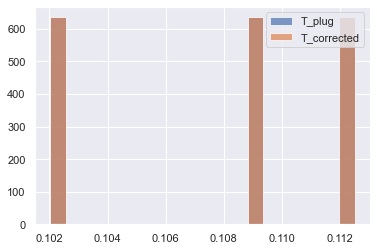

In [25]:
T_p = sim_data["T_plug"]
T_c = sim_data["T_corrected"]
T_d = sim_data["T_double"]

plt.hist(T_p,label="T_plug",bins=20,density=True, alpha=0.7); plt.legend()
plt.hist(T_c,label="T_corrected",bins=20, density=True, alpha=0.7); plt.legend()
#plt.hist(T_d,label="T_double",bins=20,density=True, alpha=0.7); plt.legend()

plt.legend()
plt.show()

In [16]:
sigT = sim_data["sigma"].apply(lambda x: x[-1])
sigT_d = sim_data["sigma_double"].apply(lambda x: x[-1])
plt.scatter(sigT,sigT_d); plt.show()

TypeError: 'float' object is not subscriptable

In [26]:
c = np.sqrt(n_samples)
p_vals_d = [1-BM_supnorm_cdf(c*x*np.sqrt(9/10)+0.01,t_max) for x,t_max in zip(T_d,sigT_d)]
p_vals_c = [1-BM_supnorm_cdf(c*x+0.01,t_max) for x,t_max in zip(T_c,sigT)]
p_vals_p = [1-BM_supnorm_cdf(c*x+0.01,t_max) for x,t_max in zip(T_p,sigT)]

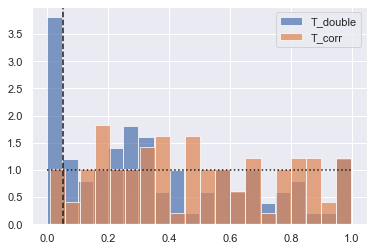

In [27]:
#plt.hist(p_vals_p,label="T_plug", density=True, alpha=0.7); plt.legend()
plt.hist(p_vals_d,label="T_double",density=True, alpha=0.7,bins=20); plt.legend()
plt.hist(p_vals_c,label="T_corr",density=True, alpha=0.7,bins=20); plt.legend()
plt.axvline(0.05,color="k", linestyle="dashed")

plt.plot(np.linspace(0,1,10),np.ones(10),"k:")

plt.show()

In [13]:
print(np.mean(p_vals_p),np.mean(p_vals_c),np.mean(p_vals_d))

6.872681505811772e-05 0.5254251213437283 0.3272295129362774


## Random

In [13]:
(gam_plug,
gam_corrected) = 0,1

In [14]:
gam_plug

0

In [37]:
a = 0.597
(a**4 - a**8) / (1-a**11) 

0.11127346156613813

In [40]:
from math import sqrt